# Model for aimpoint drift (aka ACA alignment drift) 2022-11

This notebook documents and computes fit coefficients for a simple model that
gives the relative ACA alignment as a linear function of the ACA CCD temperature.
It also includes validation of the implementation of the new model in the
`chandra_aca.drift` package.

## Summary (not updated from previous version)

This is based on the origin `fit_aimpoint_drift` notebook but updated through
2020:190 to include data from after the 2020:145 safe mode normal sun dwell.
One jump was added to the model corresponding to the 2020:145 safe mode.

The ACA alignment is measured accurately for each science observation via the apparent
positions of the fid lights.  These are referred to by their CXC aspect solution
designation as the SIM DY and DZ offsets.  This is actually a misnomer based on
the pre-launch understanding of what physical mechanism would generate such offsets.
We now know via HRMA optical axis measurements that a temperature-dependent change 
in the ACA boresight alignment is responsible.  The HRMA to SIM alignment is quite
stable.

The ACA alignment relates directly to the X-ray detector aimpoint that is used in
observation planning and analysis.  With this model it will be possible to improve
the aimpoint accuracy by introducing a dynamic pointing offset based on the
predicted ACA CCD temperature for each observation.

The model is
```
DY/Z = (t_ccd - offset) * scale + (year - 2016.0) * trend + JUMPS
```
where
```
  t_ccd : ACA CCD temperature (degF)
  scale : scaling in arcsec / degF
  offset : ACA CCD temperature corresponding to DY/Z = 0.0 arcsec
  trend : Trend in DY/Z (arcsec / year)
  year : decimal year
  jumpYYYYDDD : step function from 0.0 to jumpYYYYDDD (arcsec) for date > YYYY:DDD
```
The jumps are persistent step function changes in alignment that have been observed following
extended dwells at normal sun where the ACA gets substantially hotter than during
normal operations.  The exact mechanism is not understood, but could be due to
a non-linear stiction release of a stress point that impacts alignment.

Note that the ACA alignment has a direct linear correlation to the ACA housing temperature (AACH1T).
However, in this model we use the ACA CCD temperature as the model dependent variable because it
is linearly related to housing temperature (AACCDPT = m * AACH1T + b) as long as the TEC is at
max drive current. Since there is already
an existing Xija model to predict ACA CCD temperature this reduces duplication.

This model was fitted to data from 2012:180 to 2020:190 using Sherpa.  The key fit results are:
```
DY
-----
scale = 2.1 arcsec / degF = 3.9 arcsec / degC
trend = -0.95 arcsec / year
jumps ~ -2 to -13 arcsec

model error = +/- 1.9 arcsec (1st to 99th percentile range)

DZ
-----
scale = 1.0 arcsec / degF = 1.8 arcsec / degC
trend = -0.09 arcsec / year
jumps ~ -0.4 to -6.1 arcsec

model error = +/- 2.6 arcsec (1st to 99th percentile range)

```

The model accuracy will be degraded somewhat when ACA CCD temperature
is taken from a predictive Xija model instead of from telemetry.

*This notebook lives in the **aimpoint_mon** project repository*

## Code

In [1]:
import re
import os

# See https://stackoverflow.com/questions/59119396/
# how-to-use-django-3-0-orm-in-a-jupyter-notebook-without-triggering-the-async-con
# os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import sys

import tables
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
from astropy.table import Table
import Ska.engarchive.fetch_eng as fetch
from Ska.engarchive import fetch_sci
from Chandra.Time import DateTime
from Ska.Numpy import interpolate
from kadi import events
from sherpa import ui
from Ska.Matplotlib import plot_cxctime
from cxotime import CxoTime
from pathlib import Path
import json

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
sys.version

'3.8.12 (default, Oct 12 2021, 06:23:56) \n[Clang 10.0.0 ]'

In [3]:
%matplotlib inline

In [4]:
SIM_MM_TO_ARCSEC = 20.493

In [5]:
# Discrete jumps after 2012:001.  Note also jumps at:
#   '2008:293',  # IU-reset
#   '2010:151',  # IU-reset
#   '2011:190',  # Safe mode
JUMPS = [
    "2015:006",  # IU-reset
    "2015:265",  # Safe mode 6
    "2016:064",  # Safe mode 7
    "2017:066",  # NSM
    "2018:285",  # Safe mode 8
    "2022:294",  # Safe mode 10
]

In [6]:
ltt_bads = events.ltt_bads(pad=(0, 200000))
normal_suns = events.normal_suns(pad=(0, 100000))
safe_suns = events.safe_suns(pad=(0, 86400 * 7))

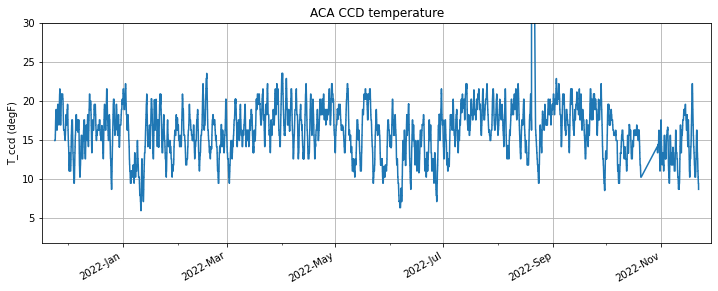

In [7]:
# Aspect camera CCD temperature trend since 2010
t_ccd = fetch.Msid("aacccdpt", start=CxoTime.now() - 365, stat="5min")
t_ccd.remove_intervals(ltt_bads | normal_suns | safe_suns)
plt.figure(figsize=(12, 4.5))
t_ccd.plot()
plt.ylabel("T_ccd (degF)")
plt.title("ACA CCD temperature")
plt.ylim(None, 30)
plt.grid()

In [8]:
# Get aspect solution DY and DZ (apparent SIM offsets via fid light positions)
# which are sampled at 1 ksec intervals and updated daily.
if "adat" not in globals():
    h5 = tables.open_file(
        f'{os.environ["SKA"]}/data/aimpoint_mon/aimpoint_asol_values.h5'
    )
    adat = h5.root.data[:]
    h5.close()

    adat.sort(order=["time"])

    # Filter bad data when asol DY and DZ are both exactly 0.0 (doesn't happen normally)
    bad = (adat["dy"] == 0.0) & (adat["dz"] == 0.0)
    adat = adat[~bad]

In [9]:
aim_obs = Table.read(
    f'{os.environ["SKA"]}/data/aimpoint_mon/observed_aimpoints.dat', format="ascii.ecsv"
)

In [10]:
# times = CxoTime(aim_obs["mean_date"]).secs
# ok = (times < bad_t0) | (times > bad_t1)
# aim_obs = aim_obs[ok]

In [11]:
def plot_observed_aimpoints(obs_aimpoints, lookback=365):
    """
    Make png plot of data in the ``obs_aimpoints`` table.
    """

    dates = DateTime(obs_aimpoints["mean_date"])
    years = dates.frac_year
    times = dates.secs
    ok = years > np.max(years) - float(lookback) / 365.25
    obs_aimpoints = obs_aimpoints[ok]
    times = times[ok]

    lolims = {}
    uplims = {}
    for axis in ("dx", "dy"):
        lolims[axis] = obs_aimpoints[axis] > 15
        uplims[axis] = obs_aimpoints[axis] < -15
        obs_aimpoints[axis] = obs_aimpoints[axis].clip(-15, 15)

    for idx, axis, label in zip([1, 2], ["dx", "dy"], ["CHIPX", "CHIPY"]):
        plt.close(idx)
        fig = plt.figure(idx, figsize=(8, 4))

        for det, c in zip(
            ["HRC-I", "HRC-S", "ACIS-I", "ACIS-S"], ["cyan", "magenta", "red", "blue"]
        ):
            offset_ok = (np.abs(obs_aimpoints["target_offset_y"]) < 100) & (
                np.abs(obs_aimpoints["target_offset_z"]) < 100
            )
            det_ok = obs_aimpoints["detector"] == det
            ok = offset_ok & det_ok
            nok = ~offset_ok & det_ok

            kwargs = dict(markeredgecolor="k", markeredgewidth=0.5, linestyle="")
            if np.count_nonzero(ok):
                plot_cxctime(
                    times[ok],
                    obs_aimpoints[axis][ok],
                    marker="o",
                    markerfacecolor=c,
                    alpha=0.5,
                    label=det,
                    **kwargs
                )
            if np.count_nonzero(nok):
                plot_cxctime(
                    times[nok],
                    obs_aimpoints[axis][nok],
                    marker="*",
                    markerfacecolor=c,
                    **kwargs
                )
            if np.any(lolims[axis]):
                plot_cxctime(
                    times[lolims[axis]],
                    obs_aimpoints[axis][lolims[axis]],
                    marker=".",
                    markerfacecolor=c,
                    yerr=1.5,
                    lolims=True,
                    **kwargs
                )
            if np.any(uplims[axis]):
                plot_cxctime(
                    times[uplims[axis]],
                    obs_aimpoints[axis][uplims[axis]],
                    marker=".",
                    markerfacecolor=c,
                    yerr=1.5,
                    uplims=True,
                    **kwargs
                )
        plt.grid()
        plt.ylim(-17, 17)
        plt.ylabel("Offset (arcsec)")
        plt.title("Observed aimpoint offsets {}".format(label))

        plt.legend(
            loc="upper left", fontsize="x-small", title="", framealpha=0.5, numpoints=1
        )

        ax = plt.gca()
        plt.plot(
            [0.5],
            [0.9],
            marker="*",
            markerfacecolor="none",
            transform=ax.transAxes,
            **kwargs
        )
        plt.text(
            0.52,
            0.9,
            "Target offset > 100 arcsec",
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize="small",
        )

        # outroot = os.path.join(opt.data_root, 'observed_aimpoints_{}'.format(axis))
        # logger.info('Writing plot files {}.png'.format(outroot))
        # fig.patch.set_visible(False)
        # plt.savefig(outroot + '.png', facecolor="none")

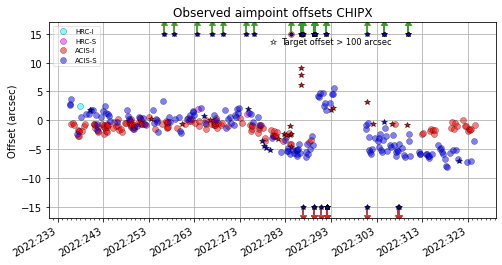

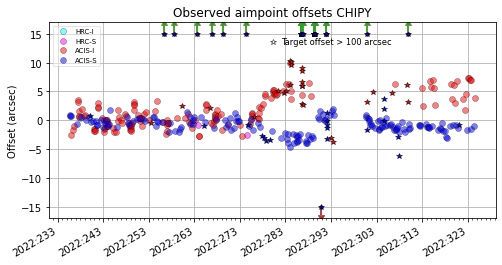

In [12]:
plot_observed_aimpoints(aim_obs, lookback=90)

In [13]:
class AcaDriftModel(object):
    """
    Class to encapsulate necessary data and compute the model of ACA
    alignment drift.  The object created from this class is called
    by Sherpa as a function during fitting.  This gets directed to
    the __call__() method.
    """

    YEAR0 = 2016.0  # Reference year for linear offset

    def __init__(self, adat, axis, start="2012:001", stop=None):
        """
        adat is the raw data array containing aspect solution data
        sampled at 1 ksec intervals.
        """
        self.axis = axis
        self.name = f"aca_drift_model_{axis}"
        
        # Get the ACA CCD temperature telemetry
        t_ccd = fetch.Msid("aacccdpt", stat="5min", start=start, stop=stop)

        # Slice the ASOL data corresponding to available ACA CCD temps
        i0, i1 = np.searchsorted(adat["time"], [t_ccd.times[0], t_ccd.times[-1]])
        self.asol = adat[i0:i1].copy()

        # Convert from mm to arcsec for convenience
        self.asol["dy"] *= SIM_MM_TO_ARCSEC
        self.asol["dz"] *= SIM_MM_TO_ARCSEC

        self.times = self.asol["time"]
        self.years = Time(self.times, format="cxcsec").decimalyear
        self.years_0 = self.years - self.YEAR0

        # Resample CCD temp. data to the 1 ksec ASOL time stamps
        self.t_ccd = interpolate(
            t_ccd.vals, t_ccd.times, self.asol["time"], method="linear"
        )

        # Get indices corresponding to jump times for later model computation
        self.jump_times = Time(JUMPS).cxcsec
        self.jump_idxs = np.searchsorted(self.times, self.jump_times)

    @property
    def model(self):
        return globals()[self.name]

    @property
    def parvals(self):
        return [par.val for par in self.model.pars]

    def __call__(self, pars, years=None, t_ccd=None):
        """
        Calculate model prediction for DY or DZ.  Params are:

          scale : scaling in arcsec / degF
          offset : ACA CCD temperature corresponding to DY/Z = 0.0 arcsec
          trend : Trend in DY/Z (arcsec / year)
          jumpYYYYDDD : discrete jump in arcsec at date YYYY:DDD
        """
        # Sherpa passes the parameters as a list
        scale, offset, trend = pars[:3]
        jumps = pars[3:]

        # Allow for passing in a different value for ACA CCD temperature
        if t_ccd is None:
            t_ccd = self.t_ccd

        # Compute linear part of model
        out = (t_ccd - offset) * scale + self.years_0 * trend

        # Put in the step function jumps
        for jump_idx, jump in zip(self.jump_idxs, jumps):
            if jump_idx > 10 and jump_idx < len(out) - 10:
                out[jump_idx:] += jump

        return out

In [14]:
def convert_json_pars_to_sherpa_pars(json_pars):
    """
    Convert a JSON pars dict into a sherpa pars dict.
    """
    sherpa_pars = {}

    for axis in "dy", "dz":
        sherpa_pars[axis] = {}
        for par, val in json_pars[axis].items():
            if par in ("scale", "offset", "trend"):
                sherpa_pars[axis][par] = val
            elif par == "jumps":
                # val is a list of 2-element lists
                for date, parval in val:
                    par = f"jump{date.replace(':', '')}"
                    sherpa_pars[axis][par] = parval

    return sherpa_pars

In [15]:
def get_aca_drift_model(axis="dy", start="2012:180", stop=None, pars_prev=None):
    """
    Use Sherpa to fit the model parameters
    """
    # Create the object used to define the Sherpa user model, then
    # load as a model and create parameters
    aca_drift = AcaDriftModel(adat, axis, start, stop)
    ui.load_user_model(aca_drift, aca_drift.name)
    parnames = ["scale", "offset", "trend"]
    parnames += ["jump{}".format(re.sub(":", "", x)) for x in JUMPS]
    ui.add_user_pars(aca_drift.name, parnames)

    if pars_prev is not None:            
        for parname, val in pars_prev[axis].items():
            par = getattr(aca_drift.model, parname)
            par.val = val
            par.freeze()

    return aca_drift

In [16]:
def fit_aimpoint_aca_temp(aca_drift):
    """
    Use Sherpa to fit the model parameters
    """
    # Get the DY or DZ values and load as Sherpa data
    dyz = aca_drift.asol[aca_drift.axis]
    ui.load_arrays(1, aca_drift.years, dyz)

    # Set the model and fit using Simplex (Nelder-Mead) minimization
    ui.set_model(1, aca_drift.model)
    ui.set_method("simplex")
    ui.fit(1)

    return ui.get_fit_results()

In [17]:
def plot_aimpoint_drift(
    axis, aca_drift, fit_results, start="2010:001", stop=None, plot_t_ccd=False
):
    """
    Plot our results
    """
    y_start = DateTime(start).frac_year
    y_stop = DateTime(stop).frac_year
    years = aca_drift.years
    ok = (years > y_start) & (years < y_stop)
    years = aca_drift.years[ok]
    times = aca_drift.times[ok]

    # Call model directly with best-fit parameters to get model values
    model = aca_drift.model
    pars = [par.val for par in model.pars]
    dyz_fit = aca_drift(pars)[ok]

    # DY or DZ values from aspect solution
    dyz = aca_drift.asol[axis][ok]
    dyz_resid = dyz - dyz_fit

    if plot_t_ccd:
        plt.figure(figsize=(12, 4.5))
        plt.subplot(1, 2, 1)

    plot_cxctime(times, dyz, label="Data")
    plot_cxctime(times, dyz_fit, "r-", alpha=0.5, label="Fit")
    plot_cxctime(times, dyz_resid, "r-", label="Residual")
    plt.title(
        "Fit aspect solution {} to scaled ACA CCD temperature".format(axis.upper())
    )
    plt.ylabel("{} (arcsec)".format(axis.upper()))
    plt.grid()
    plt.legend(loc="upper left", framealpha=1.0)

    if plot_t_ccd:
        dat = fetch_sci.Msid("aacccdpt", start, stop, stat="5min")
        plt.subplot(1, 2, 2)
        dat.plot()
        plt.grid()
        plt.ylabel("AACCCDPT (degC)")
        if isinstance(plot_t_ccd, tuple):
            plt.ylim(*plot_t_ccd)

    std = dyz_resid.std()
    p1, p99 = np.percentile(dyz_resid, [1, 99])
    print("Fit residual stddev = {:.2f} arcsec".format(std))
    print("Fit residual 99th - 1st percentile = {:.2f}".format(p99 - p1))

## Get previous drift parameters

Here we will freeze those previous parameters and only fit for the new one

In [18]:
pars_json_prev = json.load(open("aca_drift_model_2018-11.json", "r"))
pars_sherpa_prev = convert_json_pars_to_sherpa_pars(pars_json_prev)

## Fit model coefficients for DY and plot results

In [19]:
aca_drift_dy = get_aca_drift_model("dy", pars_prev=pars_sherpa_prev)    

In [20]:
aca_drift_dy.model

<UserModel model instance 'usermodel.aca_drift_model_dy'>

In [21]:
fit_dy = fit_aimpoint_aca_temp(aca_drift_dy)

Dataset               = 1
Method                = neldermead
Statistic             = chi2gehrels
Initial fit statistic = 26245.1
Final fit statistic   = 10150 at function evaluation 101
Data points           = 246960
Degrees of freedom    = 246959
Probability [Q-value] = 1
Reduced statistic     = 0.0411001
Change in statistic   = 16095.1
   aca_drift_model_dy.jump2022294   -7.97784    


In [22]:
fit_dy.parnames

('aca_drift_model_dy.jump2022294',)

Fit residual stddev = 0.90 arcsec
Fit residual 99th - 1st percentile = 4.18


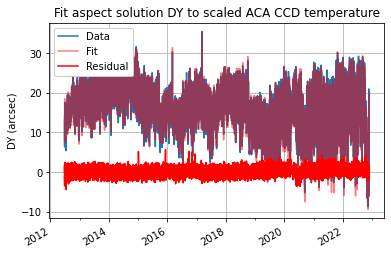

In [23]:
plot_aimpoint_drift("dy", aca_drift_dy, fit_dy)

## Zoom in around the 2022:294 safe mode time

Fit residual stddev = 0.90 arcsec
Fit residual 99th - 1st percentile = 4.29


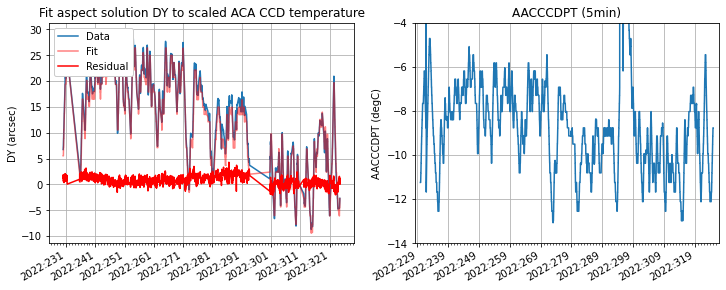

In [24]:
start = "2022:230"
stop = "2022:325"
plot_aimpoint_drift(
    "dy", aca_drift_dy, fit_dy, start=start, stop=stop, plot_t_ccd=(-14, -4)
)

### Illustrate model behavior by assuming a constant ACA CCD temperature

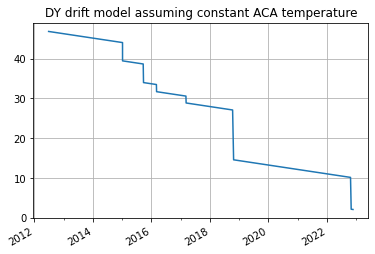

In [25]:
dyz_fit = aca_drift_dy(aca_drift_dy.parvals, t_ccd=14)  # degF = -10 C
plot_cxctime(aca_drift_dy.times, dyz_fit)
plt.title("DY drift model assuming constant ACA temperature")
plt.grid()

## Fit model coefficients for DZ and plot results

In [26]:
aca_drift_dz = get_aca_drift_model("dz", pars_prev=pars_sherpa_prev)

In [27]:
fit_dz = fit_aimpoint_aca_temp(aca_drift_dz)

Dataset               = 1
Method                = neldermead
Statistic             = chi2gehrels
Initial fit statistic = 16753.8
Final fit statistic   = 16626.9 at function evaluation 110
Data points           = 246960
Degrees of freedom    = 246959
Probability [Q-value] = 1
Reduced statistic     = 0.0673267
Change in statistic   = 126.9
   aca_drift_model_dz.jump2022294   -1.55052    


Fit residual stddev = 1.40 arcsec
Fit residual 99th - 1st percentile = 5.84


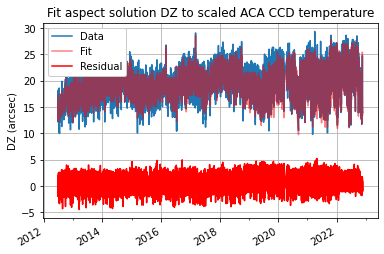

In [28]:
plot_aimpoint_drift("dz", aca_drift_dz, fit_dz)

Fit residual stddev = 0.91 arcsec
Fit residual 99th - 1st percentile = 4.12


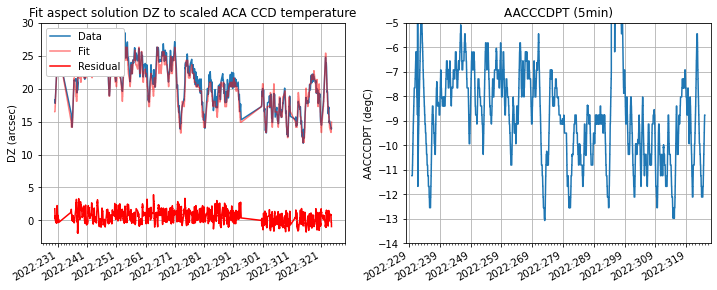

In [29]:
plot_aimpoint_drift(
    "dz", aca_drift_dz, fit_dz, start=start, stop=stop, plot_t_ccd=(-14, -5)
)

### Illustrate model behavior by assuming a constant ACA CCD temperature

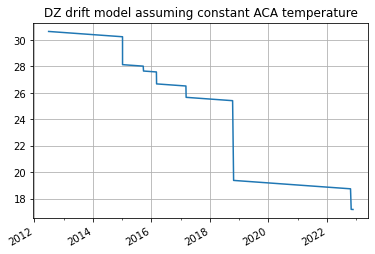

In [30]:
dyz_fit = aca_drift_dz(aca_drift_dz.parvals, t_ccd=14)  # degF = -10 C
plot_cxctime(aca_drift_dz.times, dyz_fit)
plt.title("DZ drift model assuming constant ACA temperature")
plt.grid()

In [31]:
def write_drift_pars(path, aca_drift_dy, aca_drift_dz):
    """
    Write out the fit results in a JSON file
    """
    pars = {}
    for axis, aca_drift in (("dy", aca_drift_dy), ("dz", aca_drift_dz)):
        pars[axis] = {"year0": aca_drift.YEAR0}
        jumps = []
        for par in aca_drift.model.pars:
            parname = par.name
            parval = par.val
            parname = parname.replace(f"{aca_drift.name}.", "")
            if parname.startswith("jump"):
                parname = parname.replace("jump", "")
                date = parname[:4] + ":" + parname[4:]
                jumps.append([date, round(parval, 4)])
            else:
                pars[axis][parname] = round(parval, 4)
        pars[axis]["jumps"] = jumps

    with open(path, "w") as fh:
        json.dump(pars, fh, indent=4)

In [32]:
write_drift_pars("aca_drift_model.json", aca_drift_dy, aca_drift_dz)

In [33]:
!cat aca_drift_model.json

{
    "dy": {
        "year0": 2016.0,
        "scale": 2.1466,
        "offset": -6.0122,
        "trend": -1.1078,
        "jumps": [
            [
                "2015:006",
                -4.6002
            ],
            [
                "2015:265",
                -4.6688
            ],
            [
                "2016:064",
                -1.7935
            ],
            [
                "2017:066",
                -1.7248
            ],
            [
                "2018:285",
                -12.4936
            ],
            [
                "2022:294",
                -7.9778
            ]
        ]
    },
    "dz": {
        "year0": 2016.0,
        "scale": 1.0041,
        "offset": -15.9653,
        "trend": -0.1589,
        "jumps": [
            [
                "2015:006",
                -2.1096
            ],
            [
                "2015:265",
                -0.3682
            ],
            [
                "2016:064",
                -0.902

## Comparison to current flight model for NOV1422A

Compare the actual flight `aca_offset_y/z` from the `*_dynamical_offsets.txt` files
to predictions with the new `chandra_aca.drift` module.

A key point is to use the observed mean `T_ccd` with the new model to be able to reproduce
the observed aimpoint shift of about 9 arcsec.  The jump was 13 arcsec but we did not
see that directly because of the ~1.4 C error in the temperatures being used to
predict the aimpoint offset.

In [34]:
import sys
import os
from pathlib import Path
import astropy.table as tbl
from cheta import fetch_sci

sys.path.insert(0, os.path.join(os.environ["HOME"], "git", "chandra_aca"))
os.environ["ACA_DRIFT_MODEL_PATH"] = "aca_drift_model.json"
import chandra_aca
from chandra_aca import drift
from kadi import events
from tqdm import tqdm

In [35]:
path = (
    Path(os.environ["SKA"])
    / "data"
    / "mpcrit1"
    / "mplogs"
    / "2022"
    / "NOV1422"
    / "oflsa"
    / "output"
    / "NOV1422A_dynamical_offsets.txt"
)
# Read the table but just use the first 4 rows
obss = tbl.Table.read(str(path), format="ascii.basic", guess=False)[:4]
obss

obsid,detector,chipx,chipy,chip_id,target_offset_y,target_offset_z,target_ra,target_dec,target_roll,aca_offset_y,aca_offset_z,aca_ra,aca_dec,aca_roll,mean_date,mean_t_ccd
int64,str6,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,float64
27550,ACIS-S,210.0,520.0,7,0.0,0.0,153.355957,22.208174,67.704796,0.71,-23.31,153.35714,22.186617,67.70435,2022:318:06:26:18.816,-7.49
25786,ACIS-S,210.0,520.0,7,-15.0,0.0,31.404292,64.8283,202.888115,-0.37,-23.81,31.428653,64.842497,202.866066,2022:318:10:32:18.816,-7.21
25147,ACIS-S,210.0,520.0,7,0.0,0.0,282.207083,-1.497222,291.0,5.02,-21.29,282.190544,-1.481367,290.999571,2022:319:03:12:42.816,-8.61
25930,ACIS-I,970.0,975.0,3,0.0,0.0,3.588542,-30.401222,311.228609,-7.96,-20.35,3.566728,-30.394943,311.217571,2022:319:08:10:38.816,-8.87


In [36]:
chandra_aca.test(get_version=True)

'4.36.2.dev0+gbfc07cc.d20221123-r546-bfc07cc'

In [37]:
aim_obs[0]

aca_dec,aca_offset_y,aca_offset_z,aca_ra,aca_roll,chip_id,chipx,chipy,detector,dr,dx,dy,mean_date,mean_t_ccd,obs_chipx,obs_chipy,obsid,sim_z,sim_z_off,target_dec,target_offset_y,target_offset_z,target_ra,target_roll
float64,float64,float64,float64,float64,int64,float64,float64,str6,float64,float64,float64,str21,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
86.237265,7.52,0.53,90.690629,67.667283,3,930.2,1009.6,ACIS-I,2.64,2.11,-1.58,2016:242:05:20:07.816,-13.84,621.03,707.94,18286,-233.587434461,0.00,86.239889,-150.0,150.0,89.7625,68.593411


In [38]:
start = (CxoTime.now() - 90).date
ok = ((aim_obs["mean_date"] > start)
       & (np.abs(aim_obs["target_offset_y"]) < 100)
       & (np.abs(aim_obs["target_offset_z"]) < 100))
obs_recents = aim_obs[ok]

In [39]:
t_ccd = fetch_sci.Msid("aacccdpt", start=CxoTime.now() - 100, stat="5min")

if "dx_corr" not in obs_recents.colnames:
    obs_recents["dx_corr"] = 0.0
    obs_recents["dy_corr"] = 0.0

for obs in tqdm(obs_recents):
    dwell = events.manvrs.filter(obsid=obs["obsid"])[0]
    dwell_tstart = CxoTime(dwell.kalman_start).secs
    dwell_tstop = CxoTime(dwell.next_manvr_start).secs
    i0, i1 = np.searchsorted(t_ccd.times, [dwell_tstart, dwell_tstop])
    mean_t_ccd = np.mean(t_ccd.vals[i0:i1])
    offsets = drift.get_aca_offsets(
        obs["detector"],
        chip_id=obs["chip_id"],
        chipx=obs["chipx"],
        chipy=obs["chipy"],
        time=obs["mean_date"],
        t_ccd=mean_t_ccd,
    )
    # print(obs)
    ddy = (obs["aca_offset_y"] - offsets[0])
    ddz = (obs["aca_offset_z"] - offsets[1])
    if False:
        print(
            obs["obsid"],
            obs["detector"],
            "T_ccd:",
            mean_t_ccd,
            "Obs dx, dy",
            obs["dx"],
            obs["dy"],
            "ddy ddz:",
            "%.2f" % ddy,
            "%.2f" % ddz,
        )
    if obs["detector"] == "ACIS-I":
        obs["dx_corr"] = obs["dx"] - ddz
        obs["dy_corr"] = obs["dy"] + ddy
    elif obs["detector"] == "ACIS-S":
        obs["dx_corr"] = obs["dx"] - ddy
        obs["dy_corr"] = obs["dy"] - ddz
    else:
        # Ignore HRC
        pass


100%|██████████| 301/301 [00:06<00:00, 46.44it/s]


In [40]:
obs_recents["detector", "dx_corr", "dy_corr"]

detector,dx_corr,dy_corr
str6,float64,float64
ACIS-I,-0.11932221886379968,-2.942685311403282
ACIS-I,-1.3155490251466038,-2.410975238290462
HRC-I,0.0,0.0
ACIS-S,2.4612200579140984,1.4374377410350292
ACIS-I,-0.22491073528796068,-1.4182721562890475
ACIS-I,0.060293934326718146,-1.4565821676259476
ACIS-I,0.7817243135942914,-2.2275464587498983
ACIS-S,2.630316292127767,0.8001512168568762
ACIS-S,3.0876730363353286,1.5139118375907996


## Predicted aimpoint offsets with if new model had been used

This uses the mean per-observation flight CCD temperatures, not predicted.

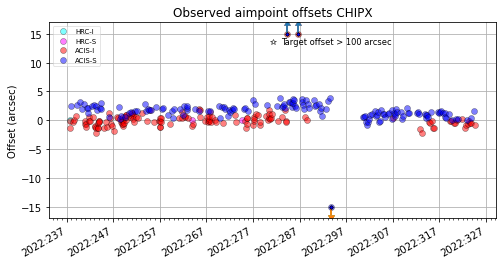

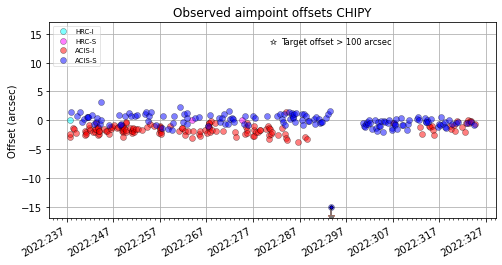

In [41]:
obs_recents_copy = obs_recents.copy()
obs_recents_copy["dx"] = obs_recents_copy["dx_corr"]
obs_recents_copy["dy"] = obs_recents_copy["dy_corr"]
plot_observed_aimpoints(obs_recents_copy)


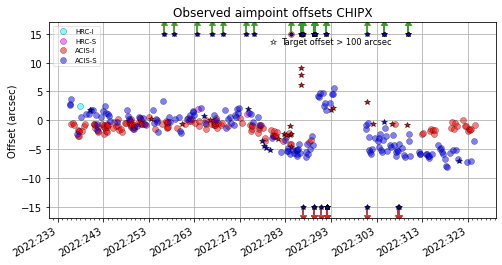

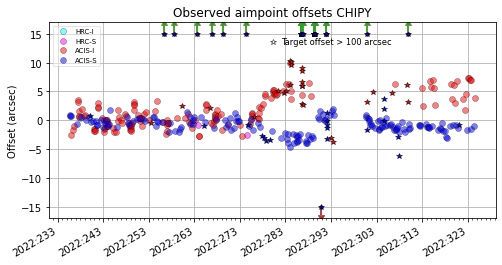

In [42]:
plot_observed_aimpoints(aim_obs, lookback=90)